In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score,
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    auc,
    classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import warnings

np.random.seed(13)

### Обзор данных

In [2]:
df = pd.read_csv('https://lms.skillfactory.ru/asset-v1:SkillFactory+MIPTDS+SEPT22+type@asset+block@train.csv')

In [3]:
# PassengerId - id пассажира, уникальна на каждую запись, не нужна для алгоритма
# Survived - выжил / не выжил, таргет
# Name - имя пассажира, не нужен для классификации
# Sex - пол пассажира
# Age - возраст пассажира
# SibSp - число братьев, сестер или супругов на борту
# Parch - оличество родителей или детей, с которыми путешествовует каждый пассажир
# Ticket - номер билета, не нужен для классификации
# Fare - сумму тарифа
# Cabin - номер кабинки
# Embarked - пункт посадки пассажира 

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df = df.drop(columns=['PassengerId', 'Name', 'Ticket'])

###  Обработка пропусков

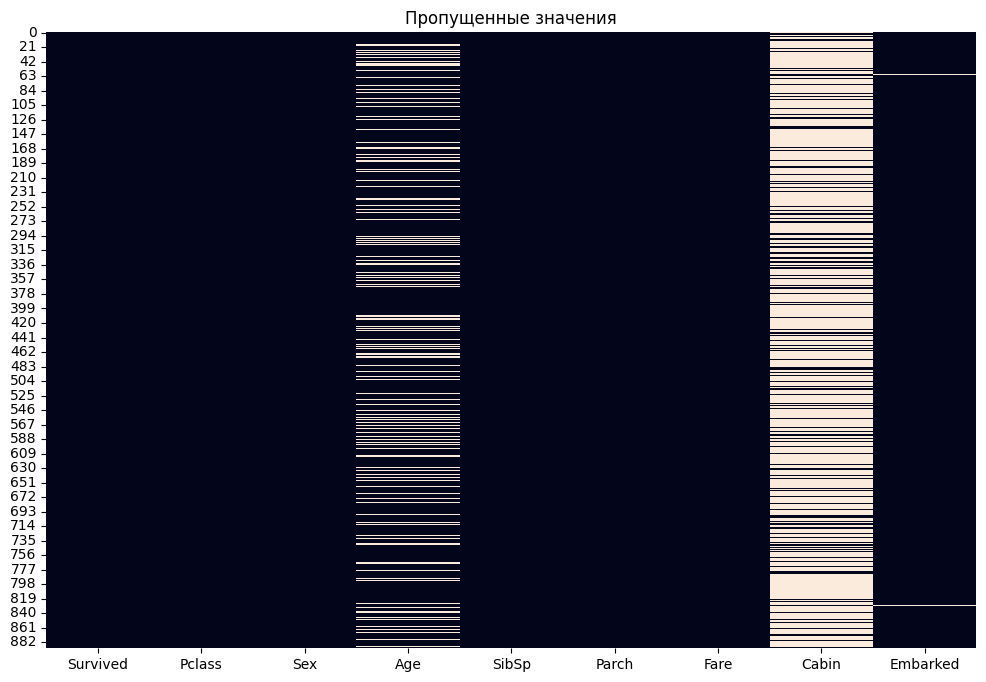

In [6]:
plt.figure(figsize=(12, 8), dpi=100)

sns.heatmap(df.isnull(), cbar=False).set_title("Пропущенные значения");

In [7]:
fill = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(fill)

In [8]:
fill = 'Na'
df['Cabin'] = df['Cabin'].fillna(fill)

In [9]:
df['Age'] = df.groupby(['Sex', 'Pclass', 'Embarked'], group_keys=False)['Age'].apply(lambda x: x.fillna(x.median()))

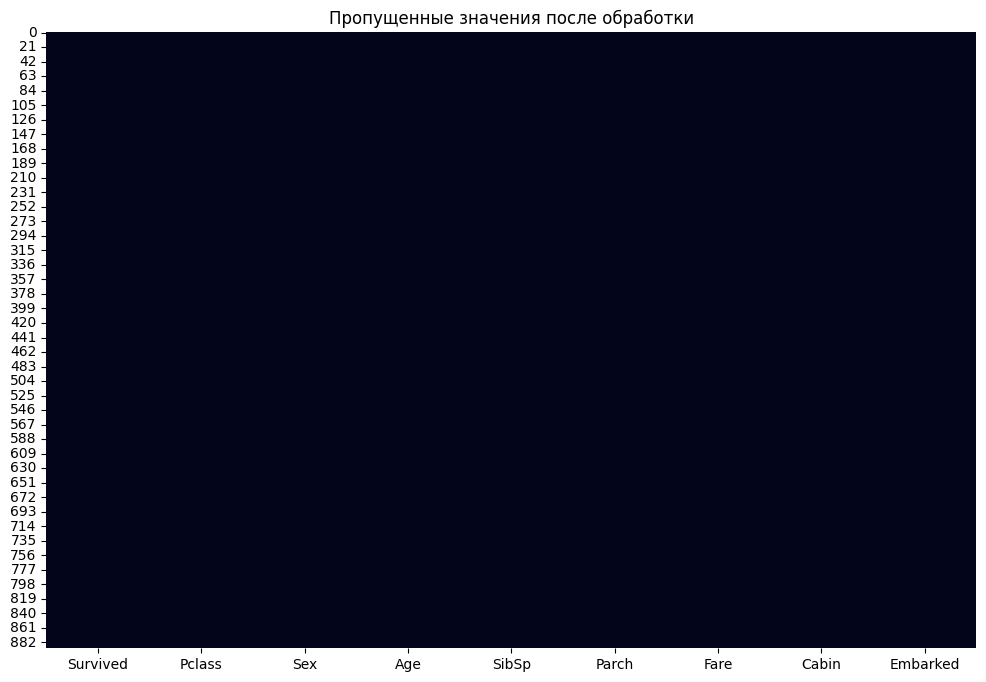

In [10]:
plt.figure(figsize=(12, 8), dpi=100)

sns.heatmap(df.isnull(), cbar=False).set_title("Пропущенные значения после обработки");

### Кодирование категориальных фичей

In [11]:
cat_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked']
for col in cat_cols:
    print(f'{col}: {df[col].nunique()} unqiue values')

Pclass: 3 unqiue values
Sex: 2 unqiue values
Cabin: 148 unqiue values
Embarked: 3 unqiue values


In [12]:
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])

dumm = pd.get_dummies(df['Pclass'], prefix='Pclass', drop_first=True)
df = pd.concat([df, dumm], axis=1)

dumm = pd.get_dummies(df['Embarked'], prefix='Embarked', drop_first=True)
df = pd.concat([df, dumm], axis=1)

df = df.drop(columns=['Cabin', 'Pclass', 'Embarked']);

### Работа с моделями

In [13]:
df['Survived'].value_counts(normalize=True)
# клссы распределены 60 на 40, не драматический перекос
# постараемся обойтись без балансировки

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [14]:
X = df.drop(columns='Survived')
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)

In [15]:
def try_model(model, X_train, y_train, X_test, y_test, param_grid=None, cv=3, scoring='roc_auc'):
    def count_versions(param_grid):
        if not param_grid:
            return 'default'
        cnt = 1
        for val in param_grid.values():
            cnt *= len(val)
        return cnt

    
    if param_grid is None:
        param_grid = dict()
    print(model.__name__, 'versions num:', count_versions(param_grid))

    # модифицировал функцию чтобы гриндсерчить по сетке гиперпараметров
    pipeline = Pipeline(
        steps=[
            ('scaler', StandardScaler()), 
            ('model', model()),
        ]
    )

    clf = GridSearchCV(
        estimator=pipeline, 
        param_grid=param_grid,
        scoring='roc_auc',
        cv=cv,
    ) 
    
    clf.fit(X_train, y_train)
    best_clf = clf.best_estimator_

    y_pred = best_clf.predict(X_test)
    
    print('Accuracy:', accuracy_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred))
    
    # из обычного питона функция display работать не будет
    try:
        display(best_clf)
    except:
        print(best_clf)

    fpr, tpr, thresholds = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.legend()
    plt.show()

    return {
        'model': best_clf,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': auc(fpr, tpr),
    }


DummyClassifier versions num: 4
Accuracy: 0.4860335195530726
Precision: 0.3283582089552239
Recall: 0.3188405797101449
F1 score: 0.3235294117647059


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DummyClassifier(strategy='stratified'))])

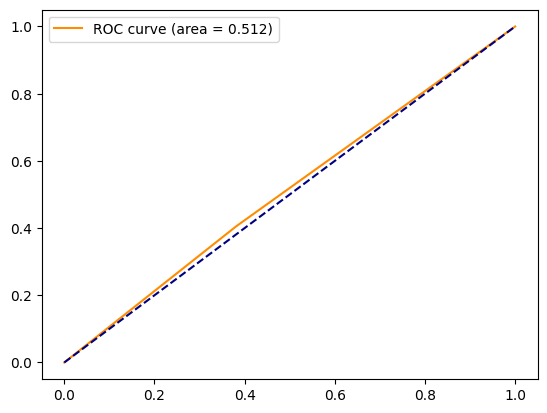

In [16]:
# пример работы, модель состоящая из Dummy стратегии

result = try_model(
    model=DummyClassifier, 

    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test,

    param_grid={'model__strategy': ['most_frequent', 'prior', 'stratified', 'uniform',]}
)


LogisticRegression versions num: 600
Accuracy: 0.776536312849162
Precision: 0.6629213483146067
Recall: 0.855072463768116
F1 score: 0.7468354430379747


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.8, class_weight='balanced',
                                    l1_ratio=0.1, random_state=13,
                                    solver='saga'))])

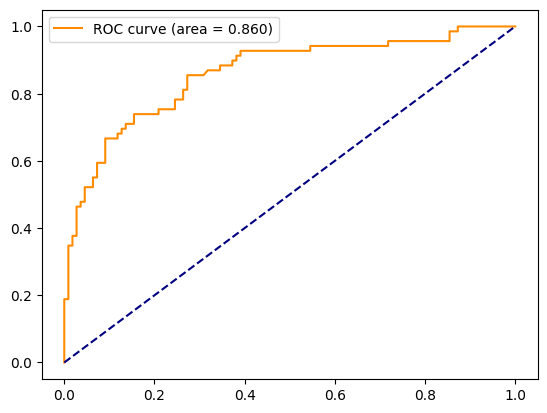

SVC versions num: 320
Accuracy: 0.770949720670391
Precision: 0.6891891891891891
Recall: 0.7391304347826086
F1 score: 0.7132867132867132


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVC(C=1, class_weight='balanced', degree=1, kernel='poly',
                     probability=True, random_state=13))])

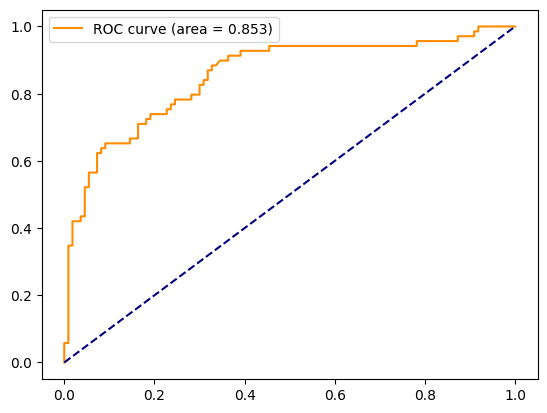

GaussianNB versions num: default
Accuracy: 0.7821229050279329
Precision: 0.7083333333333334
Recall: 0.7391304347826086
F1 score: 0.723404255319149


Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianNB())])

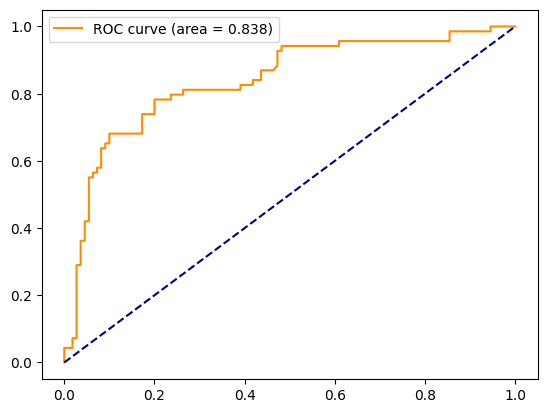

KNeighborsClassifier versions num: 196
Accuracy: 0.8324022346368715
Precision: 0.819672131147541
Recall: 0.7246376811594203
F1 score: 0.7692307692307692


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=10, p=1.5))])

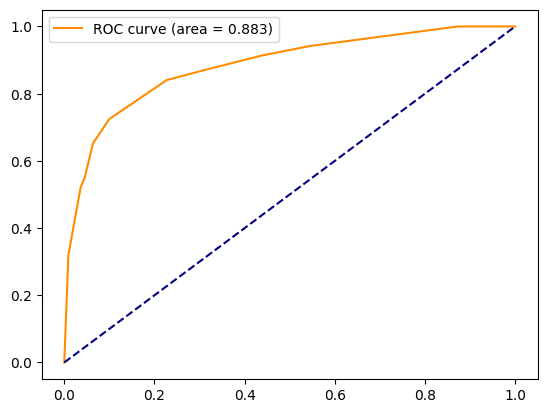

In [17]:
# обучим известные модели с гридсерчем

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


warnings.filterwarnings('ignore')

estim_lists = [
    # Логистическая регрессия
    (
        LogisticRegression,
        {
            'model__penalty': ['l2', 'elasticnet', 'none',],
            'model__solver': ['saga'],
            'model__C': np.arange(0.1, 1.1, 0.1),
            'model__l1_ratio': np.arange(0.1, 1.1, 0.1),
            'model__class_weight': ['balanced', None],
            'model__random_state': [13,],
        }
    ),

    #SVC
    (
        SVC,
        {
            'model__C': np.arange(0, 4, 1),
            'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid',],
            'model__degree': np.arange(1, 6, 1),
            'model__gamma': ['scale', 'auto'],
            'model__class_weight': ['balanced', None],
            'model__probability': [True],
            'model__random_state': [13,],
        }
    ),

    #GaussianNB
    (
        GaussianNB,
        None, 
    ),

    #KNeighborsClassifier
    (
        KNeighborsClassifier,
        {
            'model__n_neighbors': np.arange(1, 15, 1),
            'model__weights': ['uniform', 'distance'],
            'model__p': np.arange(1, 4.5, 0.5)
        }
    ),
]


model_search = []
for estimator in estim_lists:
    result = try_model(
        model=estimator[0], 

        X_train=X_train, 
        y_train=y_train, 
        X_test=X_test, 
        y_test=y_test,

        param_grid=estimator[1]
    )

    model_search.append(result)


### Выбор лучшей модели

In [18]:
models = pd.DataFrame(model_search)
models

,model,Accuracy,Precision,Recall,F1,ROC_AUC
0,"(StandardScaler(), LogisticRegression(C=0.8, c...",0.776536,0.662921,0.855072,0.746835,0.860013
1,"(StandardScaler(), SVC(C=1, class_weight='bala...",0.770950,0.689189,0.739130,0.713287,0.853426
2,"(StandardScaler(), GaussianNB())",0.782123,0.708333,0.739130,0.723404,0.838274
3,"(StandardScaler(), KNeighborsClassifier(n_neig...",0.832402,0.819672,0.724638,0.769231,0.883004


Лучшая модель:


Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=10, p=1.5))])

Accuracy: 0.8324022346368715
Precision: 0.819672131147541
Recall: 0.7246376811594203
F1 score: 0.7692307692307692


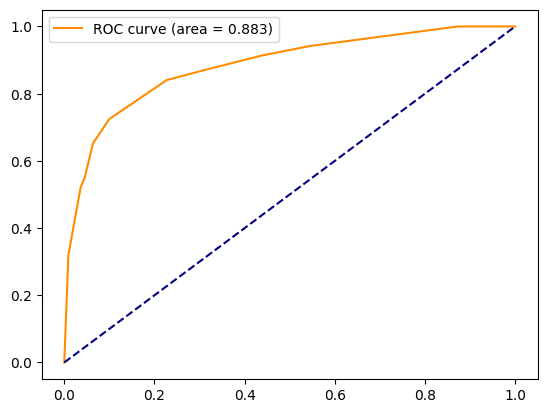

In [19]:
# В целом я хочу выбрать главной метрикой ROC_AUC - она максимально универсальна
# Но даже так видно, что и по практически всем другим метрика KNeighborsClassifier лучше конкурентов

best = models.loc[models['ROC_AUC'].idxmax()]

print('Лучшая модель:')

try:
    display(best['model'])
except:
    print(best['model'])

print('Accuracy:', best['Accuracy'])
print('Precision:', best['Precision'])
print('Recall:', best['Recall'])
print('F1 score:', best['F1'])    

fpr, tpr, thresholds = roc_curve(y_test, best['model'].predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {auc(fpr, tpr):0.3f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.legend()
plt.show()